## Logistic Regression

In [284]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [285]:
def generate(m1 , v1 , m2 , v2 , n):
    u_1 = np.random.rand(n)
    u_2 = np.random.rand(n)
    r = -2*np.log(1-u_1)
    theta = 2*np.pi*u_2
    x = r**(1/2)*np.cos(theta)
    y = r**(1/2)*np.sin(theta)
    x = np.sqrt(v1)*x + m1
    y = np.sqrt(v2)*y + m2
    return x, y

In [286]:
def plot(data1 , data2 , predict1 , predict2):
    predict1 = [int(i > 0.5) for i in predict1]
    predict2 = [int(i > 0.5) for i in predict2]
    label = np.concatenate([np.ones(len(data1[0])),np.zeros(len(data2[0]))] , axis = 0)
    x = np.concatenate([data1[0] , data2[0]] , axis = 0)
    y = np.concatenate([data1[1] , data2[1]] , axis = 0)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

    ax1.set_title("Ground truth")
    ax1.scatter(x , y , c = label)
    ax2.set_title("Gradient descent")
    ax2.scatter(x , y , c = predict1)
    ax3.set_title("Newton's method")
    ax3.scatter(x , y , c = predict2)

In [297]:
class Logistic:
    def __init__(self , data1 , data2):
        self.n = len(data1[0])
        self.x = np.concatenate([data1[0], data2[0]] , axis = 0)
        self.y = np.concatenate([data1[1] , data2[1]] , axis = 0)
        self.label = np.concatenate([np.ones(len(data1[0])),np.zeros(len(data2[0]))] , axis = 0)
        self.x_table = np.vstack([np.ones(len(self.x)) , self.x , self.y])

    def Newtons(self):
        w = np.array([0.1,0.1,0.1])
        for i in range(10000):
            y_n = 1/(1+np.exp(-w@self.x_table))
            D_mat = np.diag(y_n*(1-y_n))
            hessian = self.x_table@D_mat@self.x_table.T
            if np.sum(np.diag(D_mat) == 0) > 0:
                break
            table = np.linalg.inv(hessian)@self.x_table@(y_n-self.label)
            if sum(abs(table)) < 1e-8:
                break
            else:
                w -= table
        
        result = 1/(1+np.exp(-w@self.x_table))
        self.show(result , w , 0)
        return result
        
    def Gradient(self):
        w = np.array([0.1,0.1,0.1])
        for i in range(10000):
            y_n = 1/(1+np.exp(-w@self.x_table))
            mat = self.x_table@(y_n-self.label)
            if sum(abs(mat)) < 1e-8:
                break
            else:
                w -= mat
        
        result = 1/(1+np.exp(-w@self.x_table))
        self.show(result , w , 1)
        return result
    
    def show(self, result , w , type):
        if type == 1:
            print("Gradient descent:\n")
        else:
            print("Newton's method:\n")

        predict = [int(i > 0.5) for i in result]

        n = self.n
        TP = np.sum(predict[:n] == self.label[:n])
        FN = n - TP
        TN = np.sum(predict[n:] == self.label[n:])
        FP = n - TN
        cf = pd.DataFrame({'Predict cluster 1':[TP , FP] , 'Predict cluster 2':[FN , TN]})
        cf.index = ['Is cluster 1' , 'Is cluster 2']

        print('w:\n{}\n\nConfusion Matrix:\n{}\n'.format(w , cf))

        sensitivity = TP/n
        specificity = TN/n
        print("Sensitivity (Successfully predict cluster 1): {:.5f}".format(sensitivity))
        print("Specificity (Successfully predict cluster 2): {:.5f}".format(specificity))
        print("--------------------------------------------------------")

        

Gradient descent:

w:
[138.17932547 -48.42020607 -25.09957056]

Confusion Matrix:
              Predict cluster 1  Predict cluster 2
Is cluster 1                 40                 10
Is cluster 2                 11                 39

Sensitivity (Successfully predict cluster 1): 0.80000
Specificity (Successfully predict cluster 2): 0.78000
--------------------------------------------------------
Newton's method:

w:
[ 2.21736415 -0.67178984 -0.47497062]

Confusion Matrix:
              Predict cluster 1  Predict cluster 2
Is cluster 1                 41                  9
Is cluster 2                 12                 38

Sensitivity (Successfully predict cluster 1): 0.82000
Specificity (Successfully predict cluster 2): 0.76000
--------------------------------------------------------


/var/folders/b3/7yx_d4zx76vfl6l2fygx7f9c0000gn/T/ipykernel_33147/2332629100.py:30: RuntimeWarning: overflow encountered in exp
  y_n = 1/(1+np.exp(-w@self.x_table))


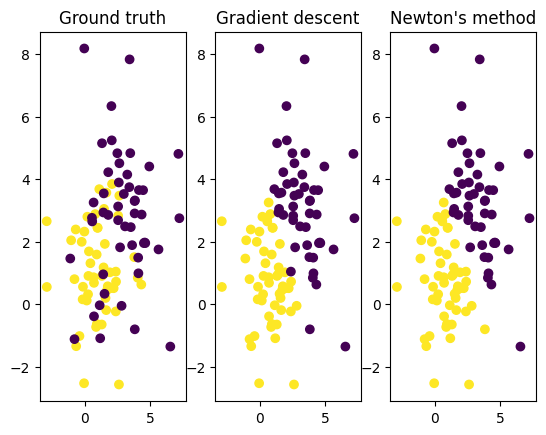

In [300]:
if __name__ == '__main__':
    n = 50
    m1 = m2 = 1
    m3 = m4 = 3
    v1 = v2 = 2
    v3 = v4 = 4
    data1 = generate(m1 , v1 , m2 , v2 , n)
    data2 = generate(m3 , v3 , m4 , v4 , n)

    model = Logistic(data1 , data2)
    gradient = model.Gradient()
    newtons = model.Newtons()
    plot(data1 , data2 , gradient , newtons)
    

## EM Algorithm

In [277]:
def unpack_file(train , label , size , col):
    train_file = open(train , "rb")
    label_file = open(label , "rb")

    train_file.read(16)
    label_file.read(8)
    images = np.zeros((size , col) )
    labels = np.zeros((size) )
    for i in range(size):
        for j in range(col):
            images[i,j] = int.from_bytes(train_file.read(1),byteorder='big')
        labels[i] = int.from_bytes(label_file.read(1),byteorder='big')

    return images , labels

In [570]:
class EM:
    def __init__(self , data ,  label):
        self.K = 10
        self.x = data
        self.label = label
        self.label_count = [np.sum(label == i) for i in range(self.K)]
        self.iter = 1000


    def E_step(self , mu , pi):
        eps = 1e-10
        gamma = np.exp(np.log(pi+eps) + self.x@np.log(mu+eps) + (1-self.x)@np.log(1-mu+eps))
        gamma /= gamma.sum(axis = 1)[: , np.newaxis]
        return gamma

    def M_step(self , gamma):
        N_k = np.sum(gamma , axis = 0)
        pi = N_k / np.sum(N_k)
        mu = self.x.T@gamma / N_k
        return pi , mu


    def train(self):
        mu = np.random.uniform(low = 0.25 , high = 0.75 , size = (self.x.shape[1] , self.K))
        pi = np.ones(self.K) / self.K
        for i in range(self.iter):
            mu_old , pi_old = mu , pi
            gamma = self.E_step(mu , pi)
            pi , mu = self.M_step(gamma)

            # self.plot_image(mu)

            delta_mu  = np.sqrt(np.sum((mu - mu_old)**2))
            delta_pi = np.sqrt(np.sum((pi - pi_old)**2))
            if delta_mu < 1e-5 and delta_pi < 1e-5:
                self.plot_image(mu)
                self.plot_result(gamma , i)
                print(delta_pi , delta_mu)
                break
        # self.plot_image(mu)
        # self.plot_result(gamma , i)


    def plot_image(self,mu):
        for k in range(self.K):
            print('class {}:'.format(k))
            for i in range(28):
                for j in range(28):
                    print('1' if mu[i*28+j][k] > 0.5 else '0' , end = ' ')
                print()
            print()
        print()

    def plot_result(self, gamma , iter):
        ans = np.argmax(gamma , axis = 1)
        for k in range(self.K):
            ans_k = set([i for i in range(len(ans)) if ans[i] == k])
            label_k = set([j for j in range(len(self.label)) if self.label[j] == k])
            TP = len(ans_k & label_k)
            FN = self.label_count[k] - TP
            FP = len(ans_k) - TP
            TN = len(ans) - self.label_count[k] - FP

            cf = pd.DataFrame({'Predict number {}'.format(k):[TP , FP] , 'Predict not number {}'.format(k):[FN , TN]})
            cf.index = ['Is number {}'.format(k) , 'Is not number {}'.format(k)]

            sensitivity = TP/self.label_count[k]
            specificity = TN/(len(ans) - self.label_count[k])

            print('Confusion Matrix {}:\n{}\n'.format(k,cf))
            print("Sensitivity (Successfully predict number {}): {:.5f}".format(k,sensitivity))
            print("Specificity (Successfully predict not number {}): {:.5f}".format(k,specificity))
            print("--------------------------------------------------------\n")
        
        err_rate = np.sum(ans != self.label)/len(ans)
        print("Total iteration to converge: {}".format(iter))
        print("Total error rate: {}".format(err_rate))

In [443]:
x_train , y_train = unpack_file("/Users/cindychen/Documents/ML_hw02/train-images.idx3-ubyte",\
    "/Users/cindychen/Documents/ML_hw02/train-labels.idx1-ubyte" , 60000 , 28*28)

In [571]:
if __name__ == "__main__":
    data = np.array(x_train > 128 , dtype = int)
    model = EM(data , y_train)
    model.train()

class 0:
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 
0 0 0 0 0 0 0 0 0 0 0 